<a href="https://colab.research.google.com/github/andrenp2/Sigmoidal_DataScience/blob/main/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e *fintechs*. Apenas no Brasil, cerca de 12,1 milhões de pessoas já foram vítimas de algum tipo de fraude financeira no último ano. Traduzindo em valores, os golpes financeiros ultrapassaram a cifra de R$ 1,8 bilhão de prejuízo por ano para os últimos 12 meses.

<p align=center>
<img src="https://images.unsplash.com/photo-1592772874383-d08932d29db7?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=699&q=80" width="60%"></p>

Dentra essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://images.unsplash.com/photo-1620714223084-8fcacc6dfd8d?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1051&q=80" width="50%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [ ]:
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
!pip install -q scikit-plot
!pip install -q skopt

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


In [ ]:
# importar os pacotes necessários

# bibliotecas 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# funções especificas de bibliotecas

# funções de metricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
#from scikitplot.metrics import plot_confusion_matrix, plot_roc

# funções de modelos (modelos de regressão, etc...)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# funções de preprocessamento (normalizacao, padronizacao, etc..)
from sklearn.preprocessing import StandardScaler

# função de balanceamento do dataset. 
from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

# Criar pipeline para padronizar > modificar > usar modelo direto
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

np.random.seed(42)

Para facilitar a aquisição dos dados, criei um *link* com acesso direto ao `csv`. Com isso, basta importar o conjunto de dados usando o método `pd.read_csv()`.

In [ ]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df = pd.read_csv(file_path)

Ao recebermos um conjunto de dados completo, o primeiro passo é serpará-lo, como demonstra a primeira figura. Então, dividiremos o conjunto inteiro entre `Treino` e `Teste`, e então separaremos o de `Treino` entre `Treino` e `Validação`.

<center><img src="https://miro.medium.com/max/1400/1*RJS8yV5mBDqrRu7THooH-w.png" width=400px ></center>

### Treino

O conjunto de treino será o maior, e será usado para a análise de dados, para criação do pipeline de processamento desses dados, e também para criar nossa *baseline*, que usaremos para selecionar o modelo a ser otimizado.

### Validação

Esse pedaço do conjunto de treino, será mais ou menos do mesmo tamanho do conjunto de teste, e será usado como um conjunto de teste. Isso significa que o modelo criado não pode ter visto esses dados na análise, assim como os de teste. Por isso esses conjuntos são comumente chamados de *"holdout sets"*, pois vamos "segurá-los" até o momento certo de usá-los.

No caso do conjunto de validação, nós vamos ter construído e selecionado o modelo, ou modelos, a serem otimizados. Nessa parte, usaremos o conjunto para fazer o tuning de parâmetros, e selecionar o melhor modelo, que será usado em produção, entregue ao cliente, etc.

### Teste

Esse conjunto é utilizado apenas no final, com o seu modelo pronto, e otimizado, para testar o resultado do modelo pronto com dados novos, da mesma forma que ele receberá esses dados no mundo real. Aqui é onde saberemos a verdadeira performance do modelo, e avaliaremos a mesma baseado nas métricas de interesse para o problema.


Ao carregar seu conjunto de dados, separe uma fração dele para ser seu conjunto de teste. É normal ver a proporção 70/15/15 para os conjuntos, mas não é uma regra.

Ainda mais hoje em dia com Big Data, não é absurdo uma proporção 95/2.5/2.5, dado o grande volume de dados, e a importância de ser ter um grande conjunto de treino.

No exemplo abaixo, vou usar 15% do dataset como conjunto de teste.

In [ ]:
# dividindo nosso dataset original em variaveis de test e treino

#dataset original
print('Dimensões do conjunto original : {}'.format(df.shape))

# teste
test = df.sample(frac=0.15, random_state=0)

# vamos retirar as variaveis de test do dataset original
df = df.drop(test.index)


print('Dimensões do conjunto treino (original - teste) : {}'.format(df.shape))
print('Dimensões do conjunto de teste : {}'.format(test.shape))

Dimensões do conjunto original : (284807, 31)
Dimensões do conjunto treino (original - teste) : (242086, 31)
Dimensões do conjunto de teste : (42721, 31)


## Análise Exploratória


### Analisando as entradas (variáveis) do dataset

Nota-se que o dataset foi alterado com transformações PCA (*Analise dos Componentes Principais*), que é um processo de combinações algebricas  realizadas entre entre variáveis. 

**PCA:**
*O objetivo é encontrar um meio de condensar a informação contida em várias variáveis originais em um conjunto menor de variáveis estatísticas (componentes) com uma perda mínima de informação.*


As entradas foram descaracterizadas para deixar em anonimato, sendo nomeadas de V1, V2, V3 ... V28

* As colunas `"Time"` e `"Amount"` foram mantidas

* E a Coluna `"Class"` nos ondica a variável **alvo**, onde:

  - **0:** Transação Normal;
  - **1:** Transação Fraudulenta;

In [ ]:
# Conhecendo o DataSet

#numero de linhas e colunas
print("Linhas : {}".format(df.shape[0]))
print("Colunas : {}".format(df.shape[1]))

Linhas : 242086
Colunas : 31


In [ ]:
# funcao head para analisar as 5 primeiras entradas do dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [ ]:
df.duplicated().sum()

801

In [ ]:
df.drop_duplicates(keep=False, inplace=True)

In [ ]:
# numero de linhas e colunas pos drop
print("Linhas : {}".format(df.shape[0]))
print("Colunas : {}".format(df.shape[1]))

Linhas : 240696
Colunas : 31


### Resumo estatistico do DataFrame

Podemos utilizar a função `.describe()` para ter um conjunto de informações resumidas do dataframe.

* Observa-se que a variavel `Amount` apresenta um **valor medio** de transição de **88.61**, **mediana** de **22.00** e **desvio padrão** de **247.65**.
  - **Valor máximo:**  19656.53
  - A maioria das transações financeiras são compostas por quantias menores, como o esperado, como vimos abaixo. 75% dos dados estão por volta dos **77.58**

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,...,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000,240696.000000
mean,94856.238209,0.010723,-0.007196,0.001899,-0.003686,0.002180,-0.002744,0.002953,-0.002040,-0.002990,...,-0.000377,0.000757,-0.000219,0.000498,-0.000209,0.000016,0.001927,0.000725,88.783765,0.001612
std,47483.505302,1.939715,1.647598,1.502012,1.414634,1.360991,1.326333,1.207994,1.177570,1.094975,...,0.719199,0.724659,0.628007,0.605179,0.521455,0.481735,0.388613,0.325100,248.035890,0.040117
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54236.500000,-0.913586,-0.601531,-0.892135,-0.850468,-0.690461,-0.770021,-0.551264,-0.209224,-0.647203,...,-0.228297,-0.543232,-0.161774,-0.354395,-0.317235,-0.327006,-0.070418,-0.052654,5.670000,0.000000
50%,84751.000000,0.023676,0.062075,0.178109,-0.022444,-0.053070,-0.275726,0.041336,0.021469,-0.052724,...,-0.028910,0.007327,-0.011175,0.040853,0.016965,-0.052315,0.001344,0.011278,22.000000,0.000000
75%,139333.000000,1.316849,0.797277,1.026511,0.738462,0.612253,0.394752,0.570361,0.324346,0.595273,...,0.186914,0.529461,0.147440,0.439696,0.350715,0.240223,0.091013,0.078235,77.960000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,23.917837,44.054461,20.007208,15.594995,...,22.614889,10.503090,22.528412,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


### Verificando Valores Ausentes

Com a função `isnull()` podemos ver a quantidade de dados nulos presentes em um dataframe. No nosso caso, pelo fato de o dataset ter sido tratado antes da utilização, o encontramos sem nenhum valor ausente em nenhuma das colunas

In [ ]:
df.isnull().sum()
#df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Balanceamento do DataSet

A partir de um gráfico de barras, podemos ver o balanceamento do dataset. Vamos avaliar a variável (coluna) `class` e comparar quantas transações foram fraudulentas com transações normais.



Quantidade de transações normais (0) : 240308
Quantidade de fraudes detectadas (1) : 388

Fraudes representam 0.1615% do dataset



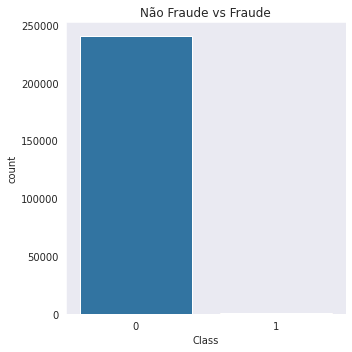

In [ ]:
# avaliando a variavel class, vamos ver quantos sao 0: sem fraudes e quantos 1: fraudulentos
normal = (df['Class'] == 0).sum()
fraude = (df['Class'] == 1).sum()

print("Quantidade de transações normais (0) : {}".format(normal))
print("Quantidade de fraudes detectadas (1) : {}".format(fraude))
print('\nFraudes representam {:.4f}% do dataset\n'.format((fraude/normal)*100))


# plotando o grafico

fig, ax = plt.subplots(figsize=(5,5))

sns.countplot('Class',data=df, ax=ax)
ax.set_title('Não Fraude vs Fraude')

plt.tight_layout()


Nota-se claramente o desbalanceamento do dataset. Iremos corrigir o problema a seguir com algumas tecnicas de padronização/normalização/parametrização 

### Avaliando histogramas das transações ao longo do tempo

* Plotar os seguintes histogramas:
    * Variável `Time`
        * Fraude (`Class == 1`)
        * Normal (`Class == 0`)
    * Variável `Amount`
        * Fraude (`Class == 1`)
        * Normal (`Class == 0`)

* Foi dividido as quantidades de transações e valores em 3 faixas representada pelas barras verticais. Nota-se que a maior quantidade de transações são para valores menores, o que ja era o esperado.

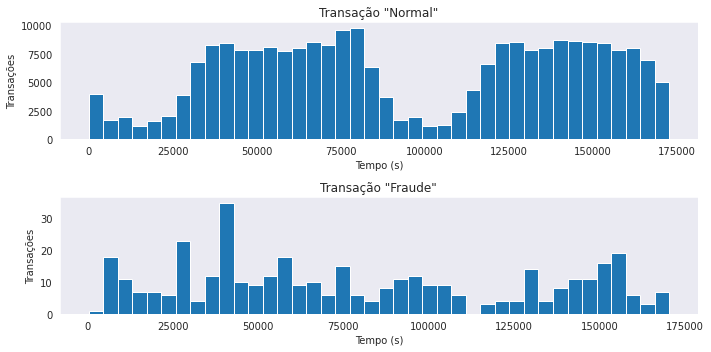

In [ ]:
# plotando histograma para 'Fraudes/NaoFraudes pelo tempo'

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5))

ax1.hist(df.Time[df.Class ==0], bins=40)
ax1.set_title('Transação "Normal"')
ax1.set_ylabel('Transações')
ax1.set_xlabel('Tempo (s)')

ax2.hist(df.Time[df.Class ==1], bins=40)
ax2.set_title('Transação "Fraude"')
ax2.set_ylabel('Transações')
ax2.set_xlabel('Tempo (s)')


plt.tight_layout()

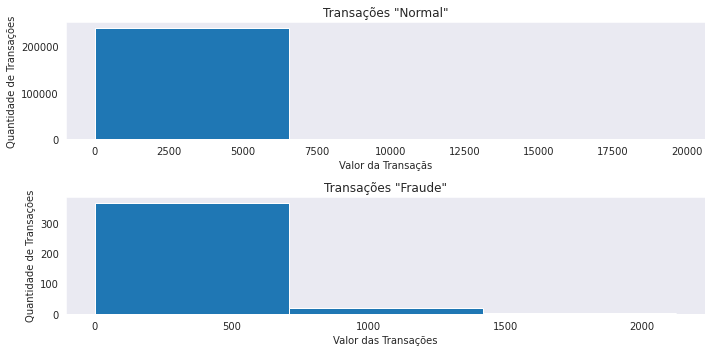

In [ ]:
# plotando histograma para transação Fraude/NaoFraude por Amount (quantidade)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,5))

ax1.hist(df.Amount[df.Class == 0], bins=3)
ax1.set_title('Transações "Normal"')
ax1.set_ylabel('Quantidade de Transações')
ax1.set_xlabel('Valor da Transaçãs')

ax2.hist(df.Amount[df.Class == 1], bins=3)
ax2.set_title('Transações "Fraude"')
ax2.set_ylabel('Quantidade de Transações')
ax2.set_xlabel('Valor das Transações')

plt.tight_layout()

### Observando os 'BoxPlot' para a variável **Amount**

* Plotar um `boxplot` para a variável `Amount` quando houve fraude (`Class == 1`)
* Plotar uma matriz de correlação

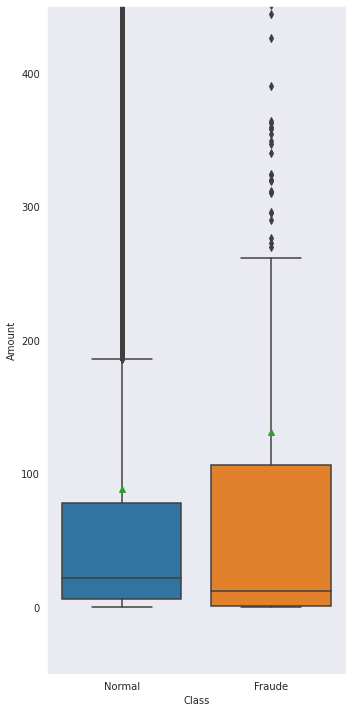

In [ ]:
# plotando boxplot para a quantidade de fraudes 
fig, ax = plt.subplots(figsize=(5,10))

#sns.boxplot(df.Amount[df.Class ==1])
sns.boxplot(df.Class,df.Amount, showmeans=True,ax=ax)
plt.ylim(-50,450)
plt.xticks([0,1], ['Normal','Fraude'])
plt.tight_layout()

O boxplot nos motra a dispersão dos dados, principalmente a mediana. Com o comando 'showmeans' conseguimos plotar a média também, representada pela seta verdade. 

A media dos valores das fraudes é: **130.92**, no caso, a maioria das transações fraudulentas são nessa faixa de valores menores. Como vimos, apesar de ter outliers (representando transações de valores maiores), são poucos.

Esse tipo de gráfico também permite enxergar a presença de *OUTLIERS*, mas nesse caso, temos que nos atentar pois os outliers podem ser as fraudes que estamos analisando, sendo assim, iremos deixa-los.

In [ ]:
# verificando as informações estatísticas para as fraudes
#df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].describe()
(df.Amount[df.Class==1]).describe()

count     388.000000
mean      130.929046
std       274.638242
min         0.000000
25%         1.000000
50%        12.310000
75%       106.637500
max      2125.870000
Name: Amount, dtype: float64

## Preparação dos Dados

* Notamos a alguns passos acima que o dataset é extremamente desbalanceado, ou seja, se olharmos para a variável `Class` onde é descrito as fraudes, vimos que o numero de fraudes equivale a **0.1615%** de todo o dataset, enquanto as transações normais ocupam o restante, **99.8385%**. Sendo assim, precisamos fazer um trabalho de pre-processamento dos dados 

* Escalonar
* Normalizar
* Padronizar

### Padronizar as colunas `Time` e `Amount`

* Iremos padronizar as colunas `Time` e `Amount` que nao foram tratadas previamente. Para isso sera utilizado a função **`StandardScaler()`** da biblioteca sklearn, e o `fit_transform`. A função `.reshape()` também é necessária, visto que precisamos de um array 2D e temos apenas 1D originalmente.

In [ ]:
# padronizar as colunas Time e Amount
df_clean = df.copy()

# definindo a função 
std = StandardScaler()

# criar as novas colunas padronizadas
df_clean['std_amount'] = std.fit_transform(df_clean['Amount'].values.reshape(-1,1))
df_clean['std_time'] = std.fit_transform(df_clean['Time'].values.reshape(-1,1))


# removendo as colunas antigas de `Amount` e `Time`
df_clean.drop(columns=['Time','Amount'], axis =1, inplace=True)

df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.245272,-1.997671
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.347103,-1.997671
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.168689,-1.997650
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.139965,-1.997650
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.075771,-1.997629


### Dividir o conjunto de dados entre treino e validação


Separando o dataset entre variáveis de treinamento e teste da maquina preditiva. 

* **X** -> Contendo as variáveis independentes (*features*) 

* **y** -> Vetor alvo contendo as variáveis dependentes (variáveis *alvos*)

* Para garantir que os conjuntos de Treino e Validação tenham a mesma quantidade de classes proporcionalmente, passamos `stratify=True`.


In [ ]:
# separando as variaveis do dataset

X = df_clean.drop('Class', axis=1)
y = df_clean['Class']

# dividindo o dataset entre treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

### Balancear o conjunto de dados

A classe desbalanceada ocorre quando temos um dataset que possui muitos exemplos de uma classe e poucos exemplos da outra classe, como é nosso caso no predsente dataset, como citado anteriormente a classe das fraudes é um valor extremamente pequeno, 0.17% enquanto a outra.

Existem problemas em que esse desbalanceamento é comum como em casos de detecção de fraudes e diagnóstico médico.

Uma vez que o número de transações financeiras normais é bem maior que o número de transações fraudulentas, assim como o número de pessoas diagnosticadas com uma determinada doença é bem menor que o número de pessoas sem a doença.

Temos algumas técnicas para lidar com esses dados,nesse tutorial vamos abordar os mais utilizados.

* **Undersampling – Consiste em reduzir de forma aleatória os exemplos da classe majoritária.** (será utilizada a seguir)

* NearMiss – É um algoritmo de undersampling que consiste em reduzir de forma aleatória os exemplos da classe majoritária, porém ele seleciona os exemplos com base na distância.

* Oversampling – Consiste em replicar dados aleatórios da classe minoritária. Como estamos duplicando os dados já existentes este método está propício a dar overfitting.

* Smote – Consiste em gerar dados sintéticos (não duplicados) da classe minoritária a partir de vizinhos.


Será utilizado a função `RandomUnderSampler`, aplicado ao `X` e `y` definido anteriormente.



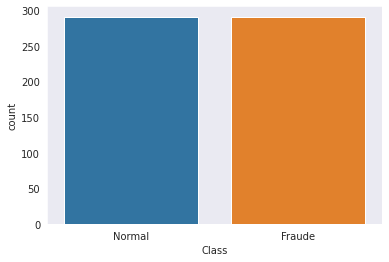

In [ ]:
# Utilizando a tecnica UnderSampling>

# CRIAR UMA FUNCAO DEF QUE IRA RECEBER CADA MODELO DE PADRONIZACAO E TESTAR E COMPARARe
# https://www.kaggle.com/code/saniyainamdar2k1/best-modelling-method-for-imbalanced-datasets

# vamos aplicar o balanceamento nas variáveis de treino

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# vizualização gráfica, 
fig, ax = plt.subplots()

sns.countplot(y_rus, ax=ax)
plt.xticks([0,1], ['Normal','Fraude'])

plt.show()


### Montando matriz de correlações

Iremos montar uma matriz de correlacoes tanto para o dataset atual, balanceado quanto para o original, e comparar graficamente se se o balanceamento foi efetivo. 

* É possivel notar que após o balanceamento do dataset ficou muito mais evidentes as correlações entre as variáveis conforme o grafico abaixo.


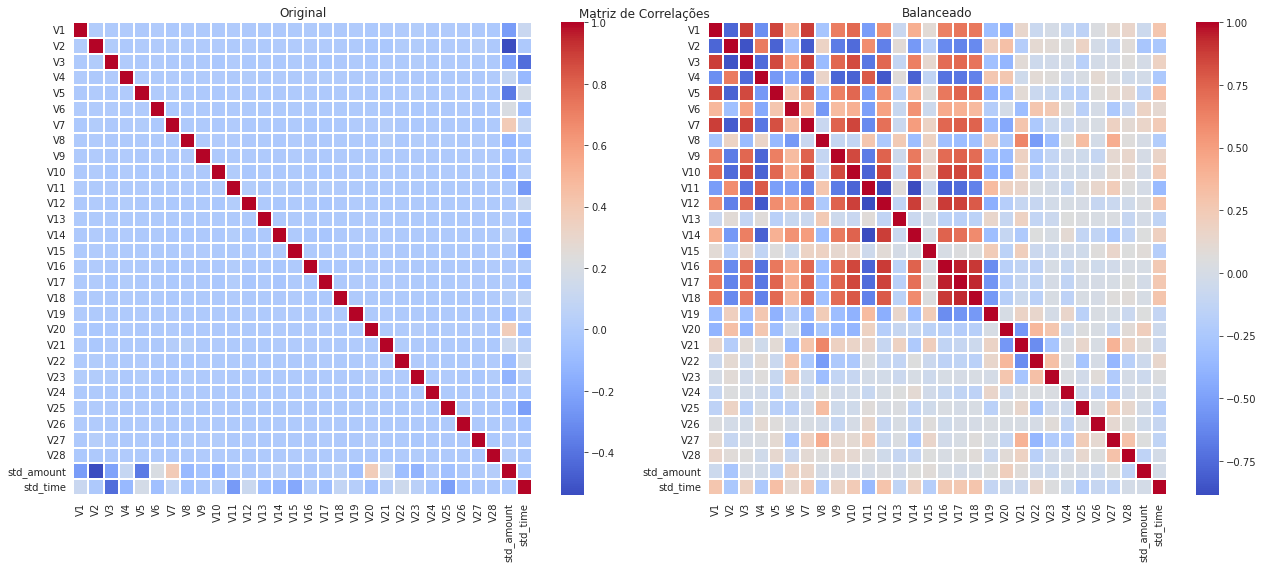

In [ ]:
# vamos criar matriz de correlações
corr = X_train.corr()
corr_balanceado = X_rus.corr()

# plotando as tuas matrizes de correlacoes

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
fig.suptitle('Matriz de Correlações')

# dataset original
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=1, cmap='coolwarm', ax=ax1)
ax1.set_title('Original')

# dataset balanceado
sns.heatmap(corr_balanceado, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=1, cmap='coolwarm', ax=ax2)
ax2.set_title('Balanceado')

plt.tight_layout()


## Modelo de Machine Learning

* Construir um modelo de **`classificação`** 

Sistemas de classificação são usados ​​geralmente quando as previsões são de natureza distinta, ou seja, um simples “sim ou não”. Exemplo: Mapeamento de uma imagem de uma pessoa e classificação como masculino ou feminino, ou nesse caso, se a transação é uma fraude ou normal. 

* Será criado uma `Função` para auxiliar a escolher o melhor modelo de machine learning! Utilizando a estatistica 

* Recall: 
Numero de exemplos verdadeiros que foram previstos corretamente, indica quão bom foi o modelo para prever os **True Positive**, sendo que os positivos são as classes que desejamos analisar, nesse caso, as fraudes.


In [ ]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

In [ ]:
rf = RandomForestClassifier() 
dt = DecisionTreeClassifier()
lgr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = [] # salvar os modelos
recall = [] # salvar os resultados do recall estatistica

#avaliar o desempenho de diversos modelos 
for clf in (rf, dt, lgr, xgb, lgbm):
  model.append(clf.__class__.__name__)
  recall.append(val_model(X_rus, y_rus, clf, quite=True))

(pd.DataFrame(data=recall, index=model, columns=['Recall'])).sort_values(by='Recall',ascending=False)


,Recall
XGBClassifier,0.910637
LGBMClassifier,0.910579
RandomForestClassifier,0.900409
DecisionTreeClassifier,0.896902
LogisticRegression,0.890006


### Escolha do Modelo:

* Entre os tres primeiros modelos de **classificação** em ordem de mais "precisão", temos:

    - `XGBClassifier` -     modelo 1
    - `LGBMClassifier` - modelo 2
    - `RandomForestClassifier` - modelo 3
    

* O modelo a ser escolhido foi o **XGBClassifier** por parecer em primeiro momento mais eficiente, por possuir o maior valor de `recall` ou seja, o modelo que mais acerta a classe observada, no nosso caso, mais acerta as transações que são fraudes.

#### Testando a maquina preditiva XGBoost sem alterar os parametros

In [ ]:
# definindo o modelo

model = XGBClassifier()

model.fit(X_rus, y_rus)

# fazer as previsões em cima dos testes

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

#### Escolhendo metricas estatísticas para avaliação do modelo

* **Matriz Confusão:** 

A matriz confusão nos retorna a classificação do modelo em:




      ```
      True Positive  | False Positive
      ---------------|----------------
      False Negative | True Negative
      ```


Onde conseguimos calcular outro parametros a partir dela, como por exemplo:

* **Acuracia:** Diz o quanto o modelo acertou das previsões. (ruim para datasets desbalanceados)
       Accuracy = prediçoes corretas / total de predições
       Accuracy = TP + TN / (TP + TN + FP + FN)

* **Recall:** Previsão dos positivos, ou seja dos acertos, verdadeiros. 
       Recall = TP / TP + FN 

* **Precisão:** Qual a proporção de identificações positivas foi realmente correta? O quão bem o modelo trabalhou
       Precisão = TP / TP + FP

* **F-Score:** Mostra o balanço entre a precisão e o recall do modelo.
       F-Score = precisão * recall / precisão + recall

* **AUC** e **ROC:** Mostra como o modelo é bom em distinguir duas coisas, no caso sim ou não, ou 0 e 1, como é nosso caso. O valor do `AUC` varia de 0,0 até 1,0 e o limiar entre a classe é 0,5. Ou seja, acima desse limite, o algoritmo classifica em uma classe e abaixo na outra classe. Quanto maior o AUC, melhor.




Relatório de classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9500    0.9743     60077
           1     0.0291    0.9278    0.0564        97

    accuracy                         0.9499     60174
   macro avg     0.5145    0.9389    0.5153     60174
weighted avg     0.9983    0.9499    0.9728     60174


Acurácia 0.9499451590387875


AUC: 0.9389



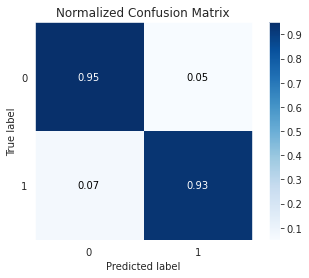

In [ ]:
# plotando os resultados

#matriz de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

#relatorio de classificacao
print('Relatório de classificação:\n',classification_report(y_test, y_pred, digits=4))

#auracia do modelo (analisar outras metricas também)
print('\nAcurácia {}\n'.format(accuracy_score(y_test, y_pred)))

#imprimir a área sobre curva, AUC (area under curve)
print('\nAUC: {:.4f}\n'.format(roc_auc_score(y_test,y_pred)))

### Encontrando ajustes otimizados para os parâmetros do XGBoost

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. 

Será definido:

* n_estimator = 
* max_depth = 
* min_child_weight = 
* gamma = 
* learning_rate = 



#### Numero de estimadores
Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1)

params = {'n_estimators':range(0,1000,50)} # testar os estimator de 0 ate 1000 de 50 em 50 

#identificar os melhores parametros
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, params, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus, y_rus)

#print 
print('Melhor: {} para {}'.format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.9345977011494252 para {'n_estimators': 100}


#### Max_depth e min_child_weight

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators = 100)

param_grid = {
    'max_depth':range(1,8,1),
    'min_child_weight':range(1,5,1)
}

#identificar os melhores paramaetros
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus, y_rus)

#print
print('Melhor: {} para {}'.format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.9311494252873563 para {'max_depth': 5, 'min_child_weight': 1}


#### Gamma

Com os valores de max_depth e min_child_weight é possivel definir o gamma:

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=5, min_child_weight=1)

param_grid = {
    'gamma':[i/10. for i in range(0,5)]
}

#identificar os melhores parametros
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus, y_rus)

#print
print('Melhor {} para {}'.format(grid_result.best_score_, grid_result.best_params_))

Melhor 0.934712643678161 para {'gamma': 0.4}


#### Learning Rate

por fim, ao determinar os parametros anteriores, será definido a melhor taxa de aprendizagem.

In [ ]:
xgb = XGBClassifier(n_estimators=100, max_depth=5, min_child_weight=1, gamma=0.4)

param_grid = {
    'learning_rate':[0.001, 0.01, 0.1, 1]
}

#identificar os melhores parametros
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus, y_rus)

#print
print('Melhor {} para {}'.format(grid_result.best_score_, grid_result.best_params_))

Melhor 0.927816091954023 para {'learning_rate': 1}


### Utilizando o modelo com os parametros ajustados.

Após encontrar os melhores parametros nos passos anteriores, vamos rodar o modelo de ML ajustado para comparar os resultados com o modelo sem ajustes.

In [ ]:
#Modelo Final
xgb = XGBClassifier(learning_rate=1, n_estimators=100, max_depth=5, min_child_weight=1, gamma=0.4)
xgb.fit(X_rus, y_rus)

#Previsão
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)


## Avaliar o desempenho do modelo

* Identificar a melhor métrica para esse tipo de modelo
* [*Opcional*] Comparar o desempenho entre diversos modelos

* Vamos analisar o relatório de classificação do modelo, disponibilizado pela função `classification_report` importada no inicio deste doc.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9440    0.9711     60077
           1     0.0261    0.9278    0.0507        97

    accuracy                         0.9440     60174
   macro avg     0.5130    0.9359    0.5109     60174
weighted avg     0.9983    0.9440    0.9697     60174


Acurácia 0.9439791271977931


AUC: 0.9359



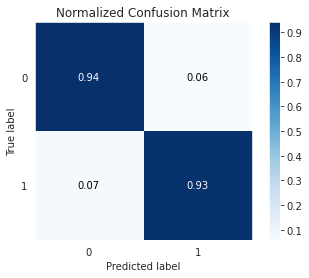

In [ ]:
#plotando os resultados

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

#relatorio de classificação
print('Relatório de Classificação:\n',classification_report(y_test, y_pred, digits=4))

#Acuracia
print('\nAcurácia {}\n'.format(accuracy_score(y_test, y_pred)))

#Imprimir a area sobre curva, AUC
print('\nAUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred)))


### Testando um outro modelo

Visto que os ajustes dos parametros não foi muito satisfatório, vamos testar um novo modelo sem ajustes apenas para analisar a diferença,

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9466    0.9725     60077
           1     0.0276    0.9381    0.0536        97

    accuracy                         0.9466     60174
   macro avg     0.5137    0.9424    0.5131     60174
weighted avg     0.9983    0.9466    0.9710     60174


Acurácia 0.9465882274736597


AUC: 0.9424



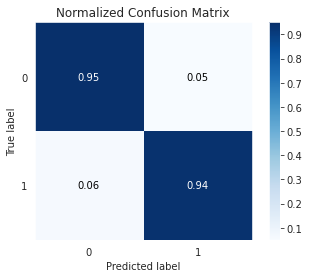

In [ ]:
# instanciar e treinar um modelo de Regressão Logística
model = LogisticRegression()
model.fit(X_rus, y_rus)

# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

#plotando os resultados

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

#relatorio de classificação
print('Relatório de Classificação:\n',classification_report(y_test, y_pred, digits=4))

#Acuracia
print('\nAcurácia {}\n'.format(accuracy_score(y_test, y_pred)))

#Imprimir a area sobre curva, AUC
print('\nAUC: {:.4f}\n'.format(roc_auc_score(y_test, y_pred)))



## Conclusão

* Analisando os 3 modelos criados nesse documento:

- XGBClassifier 
- XGBClassifier (ajustado)
- LogisticRegression

Chegamos na conclusão que o `XGBClassifier` por sí só, sem ajustes, foi o que gerou o melhor resultado. Em seguida a `regressão logística`, e por ultimo o `XGBClassifier` com os parametros ajustados. Pode-se relacionar os resultados com um ajuste ruim para esse modelo, uma vez que ao utilizarmos o `grid_search`, estamos dando os mesmos pesos para todos os parametros, e talvez algum deles influenciam mais que outros. 

Mesmo assim, os resultados do modelo XBGClassifier, sem ajustes, foram satisfatórios. Apresentando:

Acuracia: 95%
AUC: 93.89%

Além de apresentar um bom desempenho em detercar as transações fraudulentas.
